[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [2]:
# import os, getpass

# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("OPENAI_API_KEY")

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

GROQ_API_KEY=os.getenv("GROQ_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [4]:
# _set_env("LANGSMITH_API_KEY")
# os.environ["LANGSMITH_TRACING"] = "true"
# os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [5]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [6]:
from langchain_openai import ChatOpenAI
# llm = ChatOpenAI(model="gpt-4o")

from langchain_groq import ChatGroq
llm=ChatGroq(groq_api_key=GROQ_API_KEY,model='gemma2-9b-it')
llm.invoke(messages)

e:\langchain-acedmy\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


AIMessage(content='That\'s great! Whales are definitely fascinating. \n\nBeyond whales, there\'s a whole world of amazing ocean mammals to explore! Here are some suggestions, categorized for easier diving in:\n\n**Pinnipeds (seals, sea lions, and walruses):**\n\n* **Harbor seals:**  Playful and curious, they\'re often seen in coastal waters.\n* **Elephant seals:** Huge and powerful, with males reaching enormous sizes.\n* **California sea lions:**  Known for their barking calls and agility.\n* **Walruses:**  With their impressive tusks and blubbery bodies, they\'re adapted to cold Arctic waters.\n\n**Otters:**\n\n* **Sea otters:**  The smallest marine mammal, with dense fur and a love for shellfish.  \n* **Giant otters:** The largest member of the weasel family, living in South America\'s rivers.\n\n**Other fascinating ocean mammals:**\n\n* **Manatees:** Gentle giants, often called "sea cows," grazing on seagrass.\n* **Dolphins:** Highly intelligent and social, with various species foun

We can run our chat model in a simple graph with `MessagesState`.

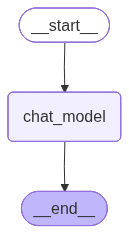

In [7]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great! Whales are amazing, but the ocean is full of fascinating marine mammals beyond them.  

Here are some other ocean mammals you could explore:

**Pinnipeds (Seals, Sea Lions, Walruses):**

* **Seals:**  They come in many shapes and sizes, from the sleek harbor seal to the massive elephant seal. Some are very social, while others are more solitary.
* **Sea Lions:**  Known for their playful nature and barking calls, sea lions are often found in large groups.
* **Walruses:**  These massive animals have distinctive tusks and use them for hauling themselves onto ice, foraging for clams, and even fighting.


## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

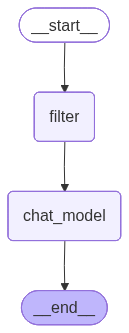

In [9]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great! Whales are amazing, but there's a whole world of fascinating ocean mammals beyond them. 

Here are a few categories and examples to get you started:

**Pinnipeds (Seals, Sea Lions, and Walruses)**

* **Harbor Seals:** These playful, curious seals are found in coastal waters around the world.
* **California Sea Lions:** Known for their barking calls and sleek bodies, they're often seen hauled out on beaches.
* **Walruses:** These giants of the Arctic have impressive tusks and spend most of their time on ice floes.

**Otters**

* **Sea Otters:** The smallest marine mammal, these fluffy creatures are h

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

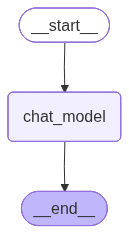

In [11]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [12]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [13]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great! Whales are amazing, but there's a whole world of fascinating ocean mammals beyond them. 

Here are a few categories and examples to get you started:

**Pinnipeds (Seals, Sea Lions, and Walruses)**

* **Harbor Seals:** These playful, curious seals are found in coastal waters around the world.
* **California Sea Lions:** Known for their barking calls and sleek bodies, they're often seen hauled out on beaches.
*

In [14]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great! Whales are amazing, but there's a whole world of fascinating ocean mammals beyond them. 

Here are a few categories and examples to get you started:

**Pinnipeds (Seals, Sea Lions, and Walruses)**

* **Harbor Seals:** These playful, curious seals are found in coastal waters around the world.
* **California Sea Lions:** Known for their barking calls and sleek bodies, they're often seen hauled out on beaches.
*

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

In [15]:
import tiktoken

# Load the tokenizer for GPT models (can be adjusted to your model)
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

def count_tokens(messages):
    total_tokens = 0
    for msg in messages:
        # Use attribute access instead of .get()
        content = msg.content if hasattr(msg, "content") else str(msg)
        total_tokens += len(encoding.encode(content))
    return total_tokens


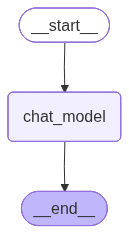

In [16]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=count_tokens,
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [18]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=count_tokens,
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [19]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r

In [20]:
messages_out_trim

{'messages': [AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
  HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
  AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
  HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4'),
  AIMessage(content='That\'s great! Whales are amazing, but there\'s a whole world of fascinating ocean mammals beyond them. \n\nHere are a few categories and examples to get you started:\n\n**Pinnipeds (Seals, Sea Lions, and Walruses)**\n\n* **Harbor Seals:** These playful, curious seals are found in coastal waters around the world.\n* **California Sea Lions:** Known for their barking calls and sleek bodies, they\'re often seen hauled out on beaches.\n* **Walruses:** These giants of the Arctic have i